We consider a system whose Hamiltonian is $H = \frac{1}{2}\omega_0 \sigma_z$, where $\sigma_z$ is a Pauli matrix.

The dynamics of the system is governed by
$\partial_t\rho=-i[H, \rho]+ \frac{\gamma}{2}(\sigma_z\rho\sigma_z-\rho)$.

Preparing the probe state at $|+\rangle$.

$\textbf{References}$

[1] J. Liu and H. Yuan, Phys. Rev. A $\textbf{96}$, 012227 (2017).

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from time import time
import torch
from datetime import datetime
import os

from AsymptoticBound.CramerRao import CramerRao
from Dynamics.learning_env import env
from Control.DDPG import DDPG, ddpg_actor, ddpg_critic
from Common.common import mat_vec_convert,  dRHO

omega0 = 1.0
gamma = [0.05]
T = 5.0
tnum = 1000
tspan = np.linspace(0, T, tnum)
cnum = 50

sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
sp, sm = 0.5*(sx+1.j*sy), 0.5*(sx-1.j*sy)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = len(rho0)

#time independent Hamiltonian
H0 = 0.5*omega0*sz
dH = [0.5*sz]

#control Hamiltonian
Hc = [sx, sy, sz]

Liouville_operator = [sz]

CRB = CramerRao()
env = env(rho0, tspan, cnum, H0, Hc, dH, Liouville_operator, gamma)

a_dim = env.ctrl_num
s_dim = env.dim**2*2
action_bound = 3.0

seed = 200
np.random.seed(seed)
torch.manual_seed(seed)

var = 1.0  # control exploration
episodes = 500
buffer_capacity = int(100*tnum)

ddpg = DDPG(a_dim, s_dim, action_bound, actor_hidn_dim=200, critic_hidn_dim=200, \
            actor_layer=3, critic_layer=0, activation='tanh', buffer_capacity=int(50*tnum), \
            batch_size=32, gamma=0.95, tau=0.02, actor_lr=0.001, critic_lr=0.002)

#=====================================================
dayTime = datetime.now().date().strftime('%Y%m%d')
path = str(dayTime)+'learning'

isexists=os.path.exists(path)
if not isexists:
    os.makedirs(path)
if os.path.exists('./'+path+'/'+'vx.txt'):
    os.remove('./'+path+'/'+'vx.txt')
if os.path.exists('./'+path+'/'+'vy.txt'):
    os.remove('./'+path+'/'+'vy.txt')
if os.path.exists('./'+path+'/'+'vz.txt'):
    os.remove('./'+path+'/'+'vz.txt')
if os.path.exists('./'+path+'/'+'reward.txt'):
    os.remove('./'+path+'/'+'reward.txt')
#=====================================================

for ei in range(episodes):
    state = env.input_state(rho0)
    dstate = np.array([np.zeros(dim**2)]).T
    
    ep_reward = 0
    vx, vy, vz = [], [], []
    for i in range(cnum):
        ctrl = ddpg.choose_action(state)
        for ci in range(len(ctrl)):
            ctrl[ci] = np.random.normal(ctrl[ci], var)

        state_, dstate_, r = env.step(ctrl, state, dstate)
        
        ddpg.store_transition(state, ctrl, r/10, state_)

        if ddpg.pointer > buffer_capacity:
            var *= .999
            ddpg.learn()

        state = state_ 
        dstate = dstate_
            
        ep_reward += r
        vx.append(ctrl[0])
        vy.append(ctrl[1])
        vz.append(ctrl[2])
        
    print('Episode:', ei, ep_reward)
    #====================================================
    f_vx = open('./'+path+'/'+'vx.txt','a')
    f_vx.write('\n')
    np.savetxt(f_vx, np.array(vx).T)
    f_vx.close()
    
    f_vy = open('./'+path+'/'+'vy.txt','a')
    f_vy.write('\n')
    np.savetxt(f_vy, np.array(vy).T)
    f_vy.close()
    
    f_vz = open('./'+path+'/'+'vz.txt','a')
    f_vz.write('\n')
    np.savetxt(f_vz, np.array(vz).T)
    f_vz.close()
        
    f_reward = open('./'+path+'/'+'reward.txt','a')
    f_reward.write('\n')
    np.savetxt(f_reward, np.array([ep_reward]).T)
    f_reward.close()
    #==================================================== 


Episode: 0 147.30139437372713
Episode: 1 224.77263946404588
Episode: 2 122.54438457595144
Episode: 3 119.2837492484364
Episode: 4 55.53296810130069
Episode: 5 114.38265346412872
Episode: 6 281.9154380402349
Episode: 7 153.9020705428576
Episode: 8 164.62552548065355
Episode: 9 189.76408307493733
Episode: 10 263.6801908251488
Episode: 11 306.2166607379104
Episode: 12 170.6241662130427
Episode: 13 164.3455636606392
Episode: 14 211.98181264649247
Episode: 15 160.81512512561028
Episode: 16 129.6468118186179
Episode: 17 151.44837874822275
Episode: 18 324.6358453528494
Episode: 19 119.47057729767384
Episode: 20 168.09717902325133
Episode: 21 114.65309892790815
Episode: 22 150.35413107637294
Episode: 23 273.68190100823307
Episode: 24 213.27338582460607
Episode: 25 195.0159793658628
Episode: 26 136.47701236542474
Episode: 27 169.67827751893535
Episode: 28 147.30855854290792
Episode: 29 153.5247633544438
Episode: 30 123.25630051915569
Episode: 31 125.64043579501414
Episode: 32 190.94416251448908

Episode: 263 165.25319755903047
Episode: 264 215.23948806582825
Episode: 265 201.83298791631105
Episode: 266 202.27216771517243
Episode: 267 108.26752588056912
Episode: 268 194.6528944611531
Episode: 269 151.6827689637101
Episode: 270 112.0734672786621
Episode: 271 200.55337118070037
Episode: 272 178.9585082776409
Episode: 273 141.52080748875233
Episode: 274 122.49141768692256
Episode: 275 248.76479044319262
Episode: 276 122.49878578322233
Episode: 277 167.17845033196753
Episode: 278 172.63199333138573
Episode: 279 190.38345968327266
Episode: 280 150.8947165547365
Episode: 281 226.51658162931997
Episode: 282 290.2283380566688
Episode: 283 203.04196342038074
Episode: 284 277.4455888554506
Episode: 285 270.3868450393714
Episode: 286 127.15047262690608
Episode: 287 127.61909509453973
Episode: 288 200.66280761094097
Episode: 289 146.10950964832162
Episode: 290 147.7003704488773
Episode: 291 163.08200307795124
Episode: 292 164.13219821113935
Episode: 293 208.23354233010355
Episode: 294 30.5

# reward

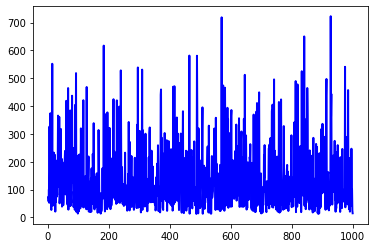

In [4]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

R = np.loadtxt('./'+'20210422learning'+'/'+'Reward.txt')
Rnum = len(R) 
total_R = R.reshape(1,Rnum)[0]
plt.plot(np.linspace(1,Rnum,Rnum),total_R,'b-',linewidth=2.0)
#plt.xlabel('Training epochs',fontsize=20)
#plt.ylabel('total reward',fontsize=20)
#plt.axis([0, 400., -7.6, -4.4])
#plt.xticks([0,100,200,300,400],fontsize=15)
#plt.yticks([-7.5,-6.5,-5.5,-4.5],fontsize=15)
#plt.legend(bbox_to_anchor = [1.0, 1.0], frameon=False,fontsize=15)
#plt.savefig('constant_value_ctrl_N8_clip15.pdf',bbox_inches = 'tight')
plt.show()

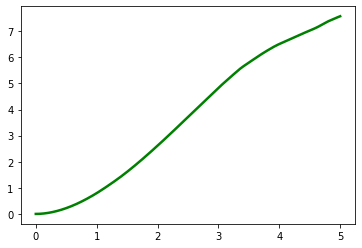

In [10]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

from AsymptoticBound.CramerRao import CramerRao
from Dynamics.dynamics import Lindblad
from Common.common import mat_vec_convert

T = 5.0
tnum = 2500
cnum = 500

vx = np.loadtxt('./'+'20210422learning'+'/'+'vx.txt')
vy = np.loadtxt('./'+'20210422learning'+'/'+'vy.txt')
vz = np.loadtxt('./'+'20210422learning'+'/'+'vz.txt')
ind = 31
num = int(tnum/cnum)

vx = vx[ind*cnum:(ind+1)*cnum].repeat(num)
vy = vy[ind*cnum:(ind+1)*cnum].repeat(num)
vz = vz[ind*cnum:(ind+1)*cnum].repeat(num)

omega0 = 1.0
gamma = [0.05]
T = 5
tnum = 2500
tspan = np.linspace(0,T, tnum)
dt = tspan[1]-tspan[0]

sx = np.array([[0.+0.j, 1.+0.j],[1.+0.j, 0.+0.j]])  
sy = np.array([[0.+0.j, 0.-1.j],[0.+1.j, 0.+0.j]]) 
sz = np.array([[1.+0.j, 0.+0.j],[0.+0.j, -1.+0.j]])
sp, sm = 0.5*(sx+1j*sy), 0.5*(sx-1j*sy)

#initial state
psi0 = np.array([[1.+0.j],[0.+0.j]])
psi1 = np.array([[0.+0.j],[1.+0.j]])
psi_p = (psi0+psi1)/np.sqrt(2)
psi_m = (psi0-psi1)/np.sqrt(2)
rho0 = np.dot(psi_p, psi_p.conj().T)
dim = len(rho0)

#time independent Hamiltonian
H0 = 0.5*omega0*sz
dH = [0.5*sz]
Liouville_operator = [sz]
H_ctrl = [sx,sy,sz]
Hc_coeff = [vx,vy,vz]

CRB = CramerRao()
    
dynamics = Lindblad(tspan, rho0, H0, H_ctrl, dH, Hc_coeff, Liouville_operator, gamma, control_option=True)
dynamics.data_generation()
rho =  dynamics.rho
drho = dynamics.rho_derivative
qfi = []
for ti in range(tnum):
    rho_ = mat_vec_convert(rho[ti])
    drho_tp = mat_vec_convert(drho[ti][0])
    drho_ = [drho_tp]
    F_q = CRB.QFIM(rho_, drho_)
    qfi.append(F_q)
    
plt.plot(tspan, qfi, 'g-', linewidth=2.5, label='QFI')

# control

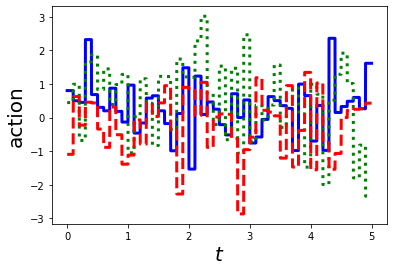

In [8]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt


T = 5.0
tnum = 2500
cnum = 50

vx = np.loadtxt('./'+'20210422learning'+'/'+'vx.txt')
vy = np.loadtxt('./'+'20210422learning'+'/'+'vy.txt')
vz = np.loadtxt('./'+'20210422learning'+'/'+'vz.txt')

ind = 2
num = int(tnum/cnum)

vx = vx[ind*cnum:(ind+1)*cnum].repeat(num)
vy = vy[ind*cnum:(ind+1)*cnum].repeat(num)
vz = vz[ind*cnum:(ind+1)*cnum].repeat(num)

plt.plot(np.linspace(0, T, tnum), vx,'b-',linewidth=3.0)
plt.plot(np.linspace(0, T, tnum), vy,'g:',linewidth=3.0)
plt.plot(np.linspace(0, T, tnum), vz,'r--',linewidth=3.0)
plt.xlabel('$t$',fontsize=20)
plt.ylabel('action',fontsize=20)

plt.show()